Optimization terminated successfully.
         Current function value: 2126.208072
         Iterations: 131
         Function evaluations: 242
Optimization terminated successfully.
         Current function value: 1937.127225
         Iterations: 146
         Function evaluations: 279
Optimization terminated successfully.
         Current function value: 112.091008
         Iterations: 115
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: 132.962967
         Iterations: 93
         Function evaluations: 179


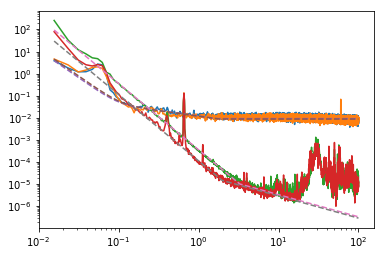

In [6]:
import dtt2hdf
import matplotlib.pyplot as plt
import numpy as np
items = dtt2hdf.read_diaggui('./data/SRM_IP_noise_20200721a.xml')
f = items.results.PSD['K1:VIS-SRM_IP_BLEND_ACCL_IN1'].FHz
lvdtl = items.results.PSD['K1:VIS-SRM_IP_BLEND_LVDTL_IN1'].PSD[0]
lvdtt = items.results.PSD['K1:VIS-SRM_IP_BLEND_LVDTT_IN1'].PSD[0]
accl = items.results.PSD['K1:VIS-SRM_IP_BLEND_ACCL_IN1'].PSD[0]
acct = items.results.PSD['K1:VIS-SRM_IP_BLEND_ACCT_IN1'].PSD[0]
mask = f>=1e-2
f = f[mask]
lvdtl = lvdtl[mask]
lvdtt = lvdtt[mask]
accl = accl[mask]
acct = acct[mask]
plt.loglog(f,lvdtl)
plt.loglog(f,lvdtt)
plt.loglog(f,accl)
plt.loglog(f,acct)
from kontrol.model import *
from kontrol import quad_sum

def low_noise_model(f, seis_N0, lvdt_N0, lvdt_fc):
    noise = quad_sum(seis_N0/f**2.5, lvdt_noise(f, lvdt_N0, lvdt_fc, exp=[-0.5,0]))
    return(noise)

# Make weight to ignore non-noise components between 0.03 and 0.2 Hz
low_noise_weight = np.ones_like(f)
for i in range(len(low_noise_weight)):
    if f[i]>0.03 and f[i]<0.2:
        low_noise_weight[i]=0
lvdtl_args = noise_fit(low_noise_model, f, lvdtl, weight = low_noise_weight)
lvdtt_args = noise_fit(low_noise_model, f, lvdtt, weight = low_noise_weight)
plt.loglog(f, low_noise_model(f, *lvdtl_args), '--')
plt.loglog(f, low_noise_model(f, *lvdtt_args), '--')

geo_noise_weight = np.ones_like(f)
# Make weight to ignore non-noise components between 0.03 and 0.2 Hz
for i in range(len(geo_noise_weight)):
    if (f[i]>0.1 and f[i]<1) or f[i]>7:
        geo_noise_weight[i]=0

def high_noise_model(f, geo_N0, geo_fc):
    return(geophone_noise(f, geo_N0, geo_fc, exp=[-3,-1]))
geol_args = noise_fit(high_noise_model, f, accl, weight = geo_noise_weight)
geot_args = noise_fit(high_noise_model, f, acct, weight = geo_noise_weight)
plt.loglog(f, high_noise_model(f, *geol_args), '--')
plt.loglog(f, high_noise_model(f, *geot_args), '--')

# plt.loglog(f, low_noise_model(f, 1e-6, 1e-6, 1))
# data=np.loadtxt('./data/SR2_IP_noise_20200720a.txt')
# f, accltxt = data[:,0], data[:,4]
# plt.loglog(f,accltxt)
# len(accltxt)
# data
# plt.semilogx(np.angle(items.results.TF['K1:VIS-SR2_IP_BLEND_ACCL_IN1'].CSD[2]))

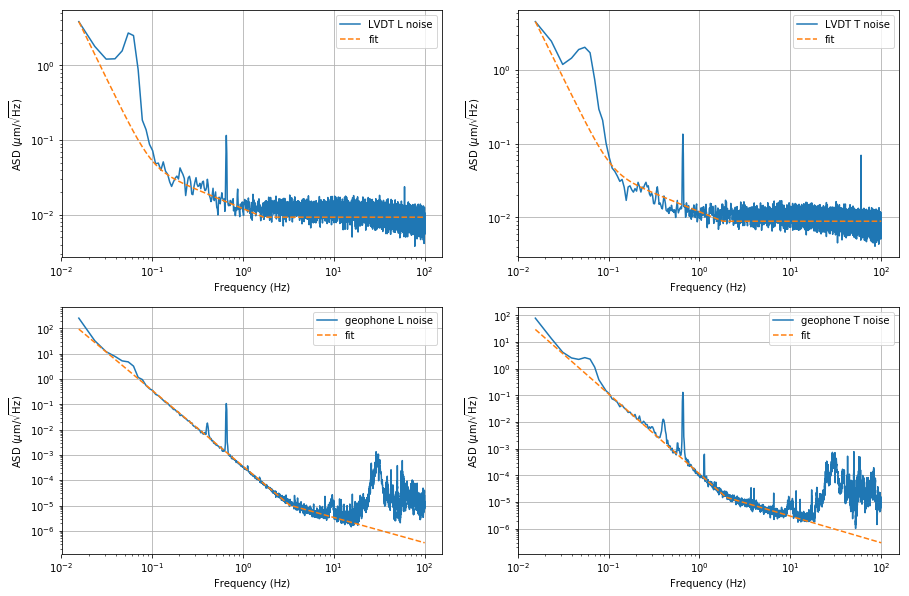

In [7]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.loglog(f,lvdtl, label='LVDT L noise')
plt.loglog(f, low_noise_model(f, *lvdtl_args), '--', label='fit')
plt.ylabel('ASD ($\mu\mathrm{m} / \sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
plt.subplot(222)
plt.loglog(f,lvdtt, label = 'LVDT T noise')
plt.loglog(f, low_noise_model(f, *lvdtt_args), '--', label = 'fit')
plt.ylabel('ASD ($\mu\mathrm{m} / \sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
plt.subplot(223)
plt.loglog(f,accl, label = 'geophone L noise')
plt.loglog(f, high_noise_model(f, *geol_args), '--', label = 'fit')
plt.ylabel('ASD ($\mu\mathrm{m} / \sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
plt.subplot(224)
plt.loglog(f,acct, label = 'geophone T noise')
plt.loglog(f, high_noise_model(f, *geot_args), '--', label = 'fit')
plt.ylabel('ASD ($\mu\mathrm{m} / \sqrt{\mathrm{Hz}}$)')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()

In [31]:
from kontrol.filter import (optimize_complementary_filter, 
    complementary_modified_sekiguchi, complementary_sekiguchi, complementary_lucia)

# f=np.linspace(0.01,10,1000)
noise_weight = np.ones_like(f)
# Make weight to ignore non-noise components between 0.03 and 0.2 Hz
# for i in range(len(noise_weight)):
#     if (f[i]>0.1 and f[i]<1):
#         noise_weight[i]=100

res = optimize_complementary_filter(
    complementary_modified_sekiguchi,
    spectra=[low_noise_model(f,*lvdtl_args)*noise_weight,high_noise_model(f,*geol_args)],
    f=f,
#     bounds=[(0.01,10),(0.01,10),(0.01,10),(0.01,10),(0.5,1000),(0.01,10),(0.5,1000)],
    bounds = [(0,1),(0,1),(0,1),(0,1)]
#     x0=[0.32,0.32,0.32,0.32]
    )
# res.x/2/np.pi

Optimizing with scipy.optimize.differential_evolution
Done. Time taken: 26.88 s The 2-norm is 4.20 unit


In [26]:
res.x

array([0.25351519, 0.34099138, 0.31797705, 0.65940889])

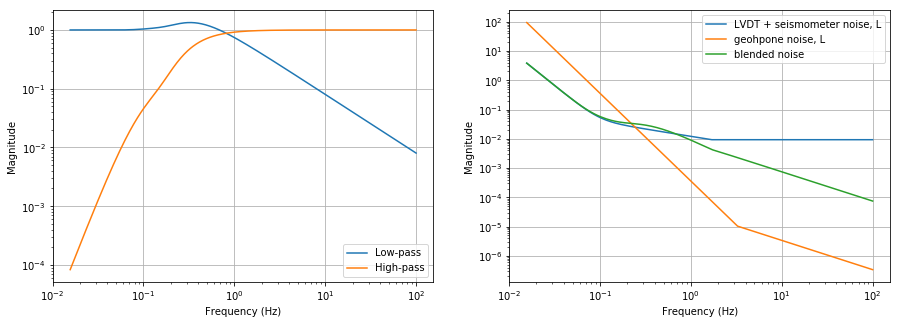

In [33]:
lpfl, hpfl = complementary_modified_sekiguchi(res.x)
# lpfl, hpfl = complementary_lucia(res.x)
# lpfl, hpfl = complementary_sekiguchi(res.x)
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.loglog(f, abs(lpfl.horner(2*np.pi*1j*f)[0][0]), label = 'Low-pass')
plt.loglog(f, abs(hpfl.horner(2*np.pi*1j*f)[0][0]), label = 'High-pass')
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
plt.subplot(122)
plt.loglog(f, low_noise_model(f,*lvdtl_args), label = 'LVDT + seismometer noise, L')
plt.loglog(f, high_noise_model(f,*geol_args), label = 'geohpone noise, L')
plt.loglog(f, quad_sum(abs(lpfl.horner(2*np.pi*1j*f)[0][0])*low_noise_model(f,*lvdtl_args),
                       abs(hpfl.horner(2*np.pi*1j*f)[0][0])*high_noise_model(f,*geol_args)), 
           label = 'blended noise')
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()

In [38]:
lpfl, hpfl

(
    5.036 s^6 + 19.01 s^5 + 33.73 s^4 + 34.51 s^3 + 20.63 s^2 + 6.854 s + 0.9757
 ----------------------------------------------------------------------------------
 s^7 + 6.975 s^6 + 20.85 s^5 + 34.63 s^4 + 34.51 s^3 + 20.63 s^2 + 6.854 s + 0.9757,
 
                      s^7 + 1.939 s^6 + 1.845 s^5 + 0.9025 s^4
 ----------------------------------------------------------------------------------
 s^7 + 6.975 s^6 + 20.85 s^5 + 34.63 s^4 + 34.51 s^3 + 20.63 s^2 + 6.854 s + 0.9757)

In [35]:
noise_weight = np.ones_like(f)
# Make weight to ignore non-noise components between 0.03 and 0.2 Hz
# for i in range(len(noise_weight)):
#     if (f[i]>0.2 and f[i]<1):
#         noise_weight[i]=10

res = optimize_complementary_filter(
    complementary_modified_sekiguchi,
    spectra=[low_noise_model(f,*lvdtt_args)*noise_weight, high_noise_model(f,*geot_args)*noise_weight],
    f=f,
#     bounds=[(0.01,10),(0.01,10),(0.01,10),(0.01,10),(0.5,1000),(0.01,10),(0.5,1000)],
    bounds=[(0,1),(0,1),(0,1),(0,1)]
#     x0=[0.32,0.32,0.32,0.32]
    )

Optimizing with scipy.optimize.differential_evolution
Done. Time taken: 23.53 s The 2-norm is 4.96 unit


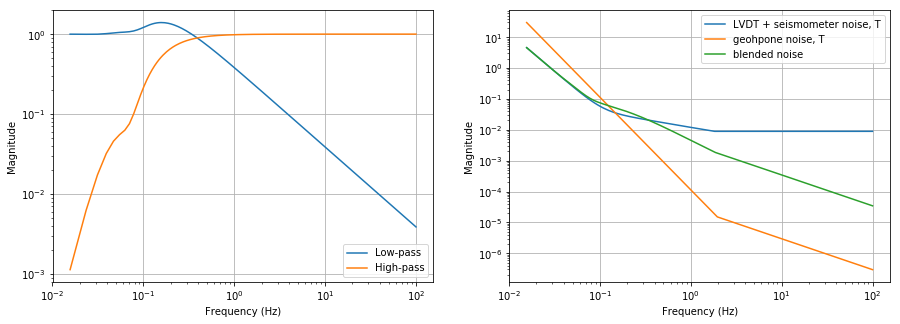

In [36]:
lpft, hpft = complementary_modified_sekiguchi(res.x)
# lpfl, hpfl = complementary_lucia(res.x)
# lpfl, hpfl = complementary_sekiguchi(res.x)
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.loglog(f, abs(lpft.horner(2*np.pi*1j*f)[0][0]), label = 'Low-pass')
plt.loglog(f, abs(hpft.horner(2*np.pi*1j*f)[0][0]), label = 'High-pass')
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()
plt.subplot(122)
plt.loglog(f, low_noise_model(f,*lvdtt_args), label = 'LVDT + seismometer noise, T')
plt.loglog(f, high_noise_model(f,*geot_args), label = 'geohpone noise, T')
plt.loglog(f, quad_sum(abs(lpft.horner(2*np.pi*1j*f)[0][0])*low_noise_model(f,*lvdtt_args),
                       abs(hpft.horner(2*np.pi*1j*f)[0][0])*high_noise_model(f,*geot_args)), 
           label = 'blended noise')
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.legend(loc=0)
plt.grid()

In [37]:
lpft, hpft

(
    2.434 s^6 + 2.863 s^5 + 1.94 s^4 + 0.7398 s^3 + 0.1693 s^2 + 0.02151 s + 0.001172
 ---------------------------------------------------------------------------------------
 s^7 + 2.669 s^6 + 3.053 s^5 + 1.94 s^4 + 0.7398 s^3 + 0.1693 s^2 + 0.02151 s + 0.001172,
 
                      s^7 + 0.2349 s^6 + 0.1902 s^5 + 3.825e-08 s^4
 ---------------------------------------------------------------------------------------
 s^7 + 2.669 s^6 + 3.053 s^5 + 1.94 s^4 + 0.7398 s^3 + 0.1693 s^2 + 0.02151 s + 0.001172)